# Notebook for the baseline model using a NN
Starting with PCA embeddings of RNA, using NN to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

In [4]:
adata.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,clr_Isotype_RTK2758,clr_Isotype_RTK4530,clr_CCR7,clr_CD62L,clr_CXCR3,clr_CD45RA,log_clone_size,TCR_mean,TCRC_mean,is_dex+
AAACCTGAGTGTTGAA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.065794,1.511381,False
AAACCTGCACCAGGCT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC1,NaN,6164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.088723,1.310205,False
AAACCTGCATACGCTA-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,5506.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,0.091682,0.705496,False
AAACGGGAGATGTGGC-1-initial-0-0,True,True,False,[],TRAC,NaN,NaN,NaN,4264.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062257,0.914930,False
AAACGGGGTACGAAAT-1-initial-0-0,True,True,False,[],TRAC,NaN,TRBC2,NaN,680.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.828641,0.064372,1.095210,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTCTGAGA-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,3450.0,NaN,...,NaN,NaN,0.54596,0.0,0.000000,0.531053,0.000000,0.081136,1.335303,False
TTTGGTTGTTCGGGCT-1-2-1,True,True,False,[],TRAC,NaN,TRBC2,NaN,892.0,NaN,...,NaN,NaN,0.54596,0.0,0.197889,0.287940,1.609438,0.078837,1.086240,False
TTTGGTTTCCACGACG-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,1186.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.360315,6.993933,0.084793,2.290340,False
TTTGTCACAGCTGCAC-1-2-1,True,True,False,[],TRAC,NaN,TRBC1,NaN,884.0,NaN,...,NaN,NaN,0.00000,0.0,0.000000,0.569542,6.993933,0.065752,1.288824,False


In [5]:
adata.var

,gene_ids,feature_types-0,genome-0,n_cells-0,feature_types-1,genome-1,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,27,Gene Expression,GRCh38,False,0.000874,1.075864,-1.150517
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,441,Gene Expression,GRCh38,False,0.023432,1.259884,-0.108835
LINC01409,ENSG00000237491,Gene Expression,GRCh38,358,Gene Expression,GRCh38,False,0.020166,1.242911,-0.204914
FAM87B,ENSG00000177757,Gene Expression,GRCh38,71,Gene Expression,GRCh38,False,0.003413,1.224581,-0.308672
LINC01128,ENSG00000228794,Gene Expression,GRCh38,1677,Gene Expression,GRCh38,False,0.097386,1.220801,-0.330072
...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,124,Gene Expression,GRCh38,True,0.006435,1.310383,0.177024
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,490,Gene Expression,GRCh38,False,0.022972,1.222385,-0.321103
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,378,Gene Expression,GRCh38,False,0.020251,1.274951,-0.023547
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,274,Gene Expression,GRCh38,False,0.024502,1.221166,-0.328006


In [6]:
print(adata.obs.donor.cat.categories.values)
print(adata.obs.time.cat.categories.values)
adata.obs[['donor','time','experiment']].head(3)

['A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A11' 'A15' 'A16' 'A19' 'A25'
 'A29' 'HIM']
['P1' 'S1' 'S2' 'S3' 'T1' 'T2' 'T3' 'X3' 'extra']


,donor,time,experiment
AAACCTGAGTGTTGAA-1-initial-0-0,A15,S2,first_experiment
AAACCTGCACCAGGCT-1-initial-0-0,A29,S2,first_experiment
AAACCTGCATACGCTA-1-initial-0-0,A15,S2,first_experiment


# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

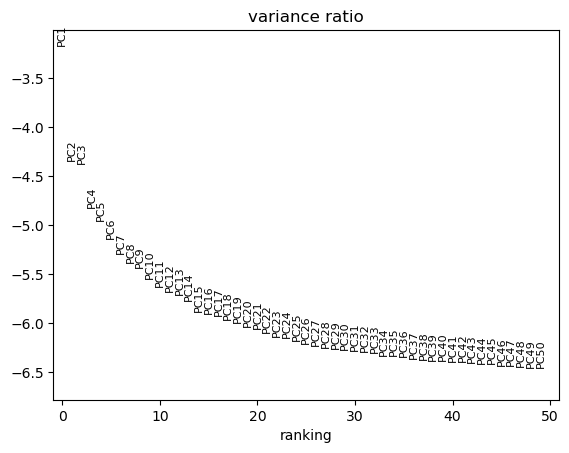

In [7]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

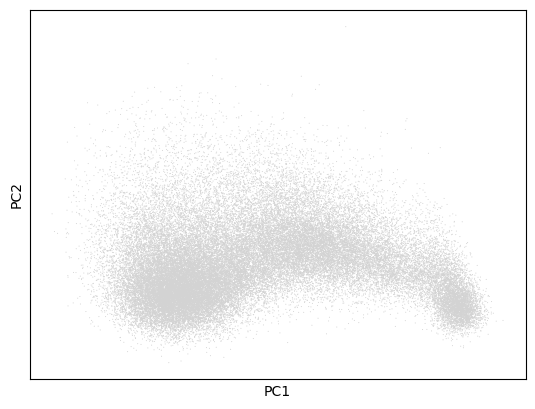

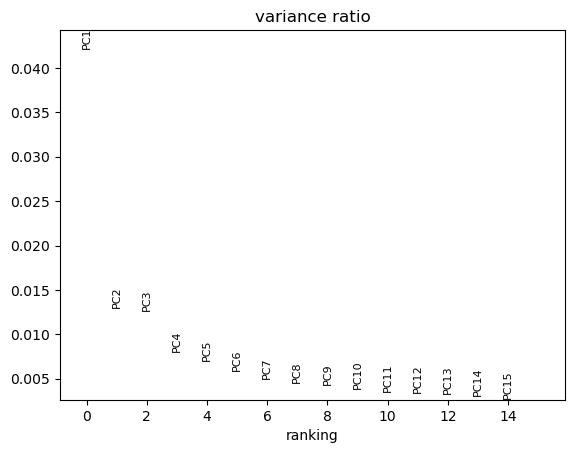

In [8]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [9]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

In [10]:
sc.pp.neighbors(adata, n_pcs=15, n_neighbors=15) # Compute the neighborhood graph
sc.tl.umap(adata) # Perform UMAP # TODO brauche ich das?????

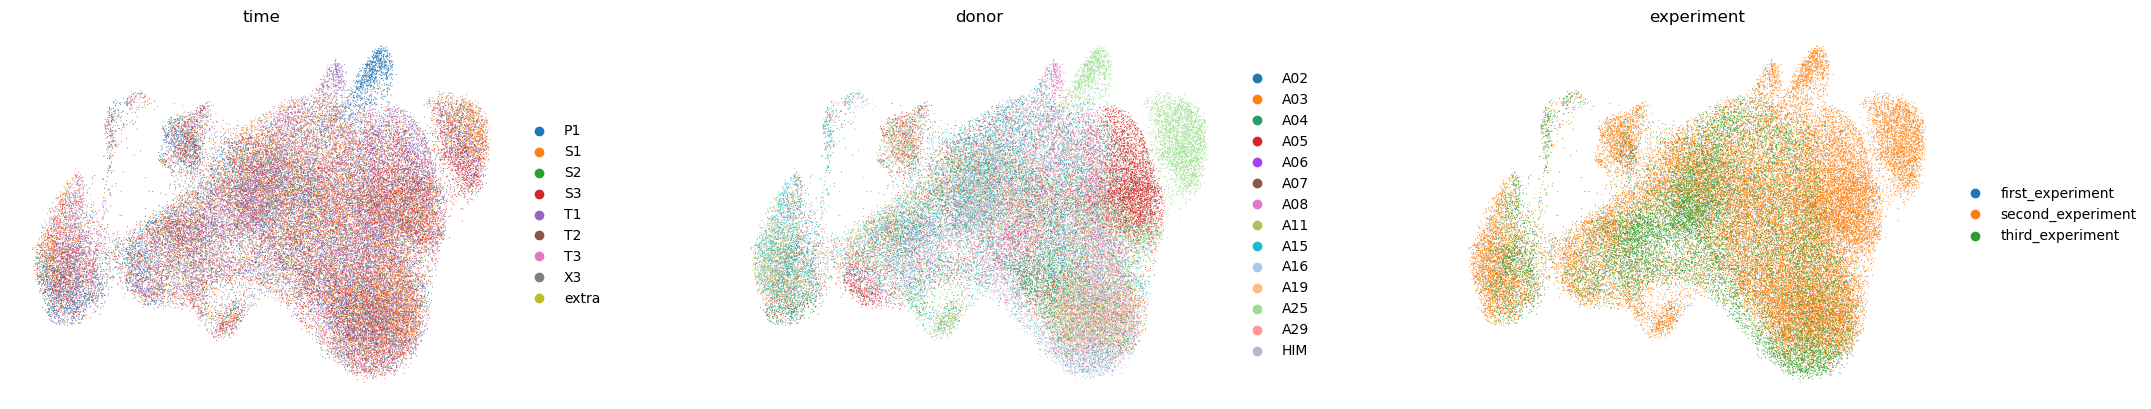

In [11]:
sc.pl.umap(adata, color=['time','donor','experiment'], frameon=False, wspace=0.3, size=2)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [12]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [13]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable
P1_clones = adata[P1_mask].obs["clone_id"].values

# Baseline Model with random cell pairing

In [14]:
from sklearn.linear_model import LinearRegression
# alternative: random pairing of cells - baseline model
# Random pairing of cells
random_indices_s1 = np.random.permutation(len(S1_targets))
random_indices_t1 = np.random.permutation(len(T1_targets))

# Shuffle and align S1 and T1 responses with P1 clones randomly
s1_random = S1_targets[random_indices_s1[:len(P1_clones)]]
t1_random = T1_targets[random_indices_t1[:len(P1_clones)]]

# Aggregate features for training
X_aggregated = []
y_s1_aggregated = []
y_t1_aggregated = []

for clone in np.unique(P1_clones):
    mask = P1_clones == clone  # Select rows for the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1_random[mask].mean())  # Randomized S1 response
    y_t1_aggregated.append(t1_random[mask].mean())  # Randomized T1 response

# Convert to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated_baseline = np.array(y_s1_aggregated)
y_t1_aggregated_baseline = np.array(y_t1_aggregated)

# Cell Pairing

## Model with Cell Pairing based on timepoints

In [15]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])
p1 = np.array([cid for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [16]:
# get cells per clonotype
clonotype_cell_counts = pd.DataFrame(P1_clones, columns=["Clonotype"]).value_counts().reset_index()
clonotype_cell_counts.columns = ["Clonotype", "Cell Count"]

# Display the counts per clonotype
clonotype_cell_counts.head()

,Clonotype,Cell Count
0,897.0,297
1,926.0,216
2,30.0,160
3,870.0,141
4,171.0,136


In [17]:
adata.obs["clone_id"].value_counts()

clone_id
897.0      2388
30.0       1124
926.0      1090
171.0       995
855.0       747
           ... 
6607.0        1
6608.0        1
6610.0        1
6611.0        1
20300.0       1
Name: count, Length: 12701, dtype: int64

## Split into Train-Val-Test

 The splitting is done based on the unique clonotypes (unique_clonotypes_aggregated) to ensure that clones seen in the training set are not present in the test set. Here, a 80-20 split is used.

 Possible options to avoid biases:
 - split to maintain the distribution of responses in both train and test sets
 - additionally divide based on donor or experiment


### Split by Timepoint

In [18]:
from sklearn.model_selection import train_test_split

# Extract unique clonotypes from P1
unique_clonotypes_aggregated = np.unique(P1_clones) 

# Train-test split by optimal transport aggregation
train_clonotypes, test_clonotypes  = train_test_split(unique_clonotypes_aggregated, test_size=0.2, random_state=42)

# Create masks for train and test sets based on the asigned clonotypes
train_mask = np.isin(unique_clonotypes_aggregated, train_clonotypes)
test_mask = np.isin(unique_clonotypes_aggregated, test_clonotypes)

# Recreate aggregated arrays aligned with unique clonotypes
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []
test_s1_clonotypes = []
test_t1_clonotypes = []


# Aggregate features and targets by clone
for clone in unique_clonotypes_aggregated:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1[mask].mean())      # Mean of s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of t1 for the clone
    if s1[mask] is not np.nan:
        test_s1_clonotypes.append(clone)             # Save the clonotype for test set
    elif t1[mask] is not np.nan:
        test_t1_clonotypes.append(clone)             # Save the clonotype for test set


# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)


# Split aggregated data into train and test sets
X_s1_train, X_s1_test = X_aggregated[train_mask], X_aggregated[test_mask]
X_t1_train, X_t1_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]

# Using Pytorch

In [19]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import shutil


## Convert Dataframes to Tensors

In [20]:
# Convert data to PyTorch tensors
X_s1_train_tensor = torch.tensor(X_s1_train, dtype=torch.float32)
y_s1_train_tensor = torch.tensor(y_s1_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for output
X_s1_test_tensor = torch.tensor(X_s1_test, dtype=torch.float32)
y_s1_test_tensor = torch.tensor(y_s1_test, dtype=torch.float32).unsqueeze(1)

X_t1_train_tensor = torch.tensor(X_t1_train, dtype=torch.float32)
y_t1_train_tensor = torch.tensor(y_t1_train, dtype=torch.float32).unsqueeze(1)
X_t1_test_tensor = torch.tensor(X_t1_test, dtype=torch.float32)
y_t1_test_tensor = torch.tensor(y_t1_test, dtype=torch.float32).unsqueeze(1)

In [21]:
device = torch.device('mps')

In [22]:
# Setting up Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/simple_nn")

## Initializing a simple NN

In [23]:
# setup NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [24]:
# Initialize models
input_size = X_s1_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Single output (regression)

# Models for S1 and T1
model_s1 = SimpleNN(input_size, hidden_size, output_size)
model_t1 = SimpleNN(input_size, hidden_size, output_size)

In [25]:
## Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=0.001)
optimizer_t1 = optim.Adam(model_t1.parameters(), lr=0.001)


## Train

In [26]:
def train_model(X_train, y_train, X_test, y_test, input_size, hidden_size, lr, num_epochs=50):
    # Define the model
    model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor).item()

    return test_loss

In [27]:
# old Training code 
num_epochs = 100

# Training loop for S1
for epoch in range(num_epochs):
    # Forward pass
    outputs = model_s1(X_s1_train_tensor)
    loss = criterion(outputs, y_s1_train_tensor)

    # Backward pass and optimization
    optimizer_s1.zero_grad()
    loss.backward()
    optimizer_s1.step()

    # Log training loss
    writer.add_scalar("Loss/Train_S1", loss.item(), epoch)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Close the writer when done
writer.close()


# Training loop for T1
for epoch in range(num_epochs):
    # Forward pass for T1
    model_t1.train()
    outputs = model_t1(X_t1_train_tensor)
    loss = criterion(outputs, y_t1_train_tensor)
    
    # Backward pass and optimization
    optimizer_t1.zero_grad()
    loss.backward()
    optimizer_t1.step()

    # Log training loss
    writer.add_scalar("Loss/Train_T1", loss.item(), epoch)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss (T1): {loss.item():.4f}')


Epoch [10/100], Loss: 0.0734
Epoch [20/100], Loss: 0.0575
Epoch [30/100], Loss: 0.0482
Epoch [40/100], Loss: 0.0428
Epoch [50/100], Loss: 0.0394
Epoch [60/100], Loss: 0.0370
Epoch [70/100], Loss: 0.0351
Epoch [80/100], Loss: 0.0335
Epoch [90/100], Loss: 0.0321
Epoch [100/100], Loss: 0.0310
Epoch [10/100], Loss (T1): 0.1206
Epoch [20/100], Loss (T1): 0.1045
Epoch [30/100], Loss (T1): 0.0974
Epoch [40/100], Loss (T1): 0.0912
Epoch [50/100], Loss (T1): 0.0861
Epoch [60/100], Loss (T1): 0.0817
Epoch [70/100], Loss (T1): 0.0777
Epoch [80/100], Loss (T1): 0.0741
Epoch [90/100], Loss (T1): 0.0708
Epoch [100/100], Loss (T1): 0.0677


## Param Tune

In [28]:
import random

# Define hyperparameter ranges
hidden_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
num_samples = 10

# Random search
best_params = None
best_loss = float('inf')

for _ in range(num_samples):
    hidden_size = random.choice(hidden_sizes)
    lr = random.choice(learning_rates)
    test_loss = train_model(
        X_train=X_s1_train,
        y_train=y_s1_train,
        X_test=X_s1_test,
        y_test=y_s1_test,
        input_size=X_s1_train.shape[1],
        hidden_size=hidden_size,
        lr=lr,
        num_epochs=num_epochs,
    )
    print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}, Test Loss: {test_loss:.4f}")
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = {"hidden_size": hidden_size, "lr": lr}

print(f"Best Params: {best_params}, Best Loss: {best_loss:.4f}")

Hidden Size: 32, Learning Rate: 0.0001, Test Loss: 0.0928
Hidden Size: 128, Learning Rate: 0.001, Test Loss: 0.0608
Hidden Size: 64, Learning Rate: 0.001, Test Loss: 0.0669
Hidden Size: 32, Learning Rate: 0.01, Test Loss: 0.0909
Hidden Size: 64, Learning Rate: 0.01, Test Loss: 0.0782
Hidden Size: 128, Learning Rate: 0.0001, Test Loss: 0.0865
Hidden Size: 128, Learning Rate: 0.001, Test Loss: 0.0685
Hidden Size: 128, Learning Rate: 0.01, Test Loss: 0.0770
Hidden Size: 64, Learning Rate: 0.0001, Test Loss: 0.1321
Hidden Size: 128, Learning Rate: 0.0001, Test Loss: 0.0944
Best Params: {'hidden_size': 128, 'lr': 0.001}, Best Loss: 0.0608


In [29]:
best_hidden_size = best_params["hidden_size"]
best_lr = best_params["lr"]

final_loss = train_model(
    X_train=X_s1_train,
    y_train=y_s1_train,
    X_test=X_s1_test,
    y_test=y_s1_test,
    input_size=X_s1_train.shape[1],
    hidden_size=best_hidden_size,
    lr=best_lr,
    num_epochs=100,  # Use more epochs for final training
)

print(f"Final Test Loss: {final_loss:.4f}")

Final Test Loss: 0.0605


Starting tensorboard from terminal:

tensorboard --logdir=runs

## Eval
TODO here, evaluation per clonotype is missing

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate S1 model
model_s1.eval()
with torch.no_grad():
    y_s1_pred = model_s1(X_s1_test_tensor).squeeze()  # Remove extra dimension
    s1_test_loss = criterion(y_s1_pred, y_s1_test_tensor).item()  # MSE loss

    # Convert predictions and targets to NumPy
    y_s1_pred_np = y_s1_pred.numpy()
    y_s1_test_np = y_s1_test_tensor.squeeze().numpy()

    # MSE
    mse_s1 = mean_squared_error(y_s1_test_np, y_s1_pred_np)

    # Mean clonotype activation
    mean_activation_s1 = np.mean(y_s1_pred_np)
    real_activation_s1 = np.mean(y_s1_test_np)

    # Recall @ k (e.g., k = 5)
    k = 5
    top_k_true = np.argsort(y_s1_test_np)[-k:]  # Indices of top k true activations
    top_k_pred = np.argsort(y_s1_pred_np)[-k:]  # Indices of top k predicted activations
    recall_at_k_s1 = len(set(top_k_true) & set(top_k_pred)) / len(top_k_true)

print(f'S1 Metrics:')
print(f'  MSE: {s1_test_loss:.4f}')
print(f'  Mean Activation: {real_activation_s1:.4f}')
print(f'  Mean Activation Pred: {mean_activation_s1:.4f}')
print(f'  Recall @ {k}: {recall_at_k_s1:.4f}')

# Evaluate T1 model
model_t1.eval()
with torch.no_grad():
    y_t1_pred = model_t1(X_t1_test_tensor).squeeze()
    t1_test_loss = criterion(y_t1_pred, y_t1_test_tensor).item()

    # Convert predictions and targets to NumPy
    y_t1_pred_np = y_t1_pred.numpy()
    y_t1_test_np = y_t1_test_tensor.squeeze().numpy()

    # MSE
    mse_t1 = mean_squared_error(y_t1_test_np, y_t1_pred_np)

    # Mean clonotype activation
    mean_activation_t1 = np.mean(y_t1_pred_np)
    real_activation_t1 = np.mean(y_t1_test_np)

    # Recall @ k (e.g., k = 5)
    top_k_true = np.argsort(y_t1_test_np)[-k:]
    top_k_pred = np.argsort(y_t1_pred_np)[-k:]
    recall_at_k_t1 = len(set(top_k_true) & set(top_k_pred)) / len(top_k_true)

print(f'T1 Metrics:')
print(f'  MSE: {t1_test_loss:.4f}')
print(f'  Mean Activation: {real_activation_t1:.4f}')
print(f'  Mean Activation Pred: {mean_activation_t1:.4f}')
print(f'  Recall @ {k}: {recall_at_k_t1:.4f}')



S1 Metrics:
  MSE: 0.0680
  Mean Activation: -0.0367
  Mean Activation Pred: -0.0419
  Recall @ 5: 0.0000
T1 Metrics:
  MSE: 0.1441
  Mean Activation: 0.0765
  Mean Activation Pred: 0.0658
  Recall @ 5: 0.4000


# Visualizations of all Models for Presentation (Hardcoded)

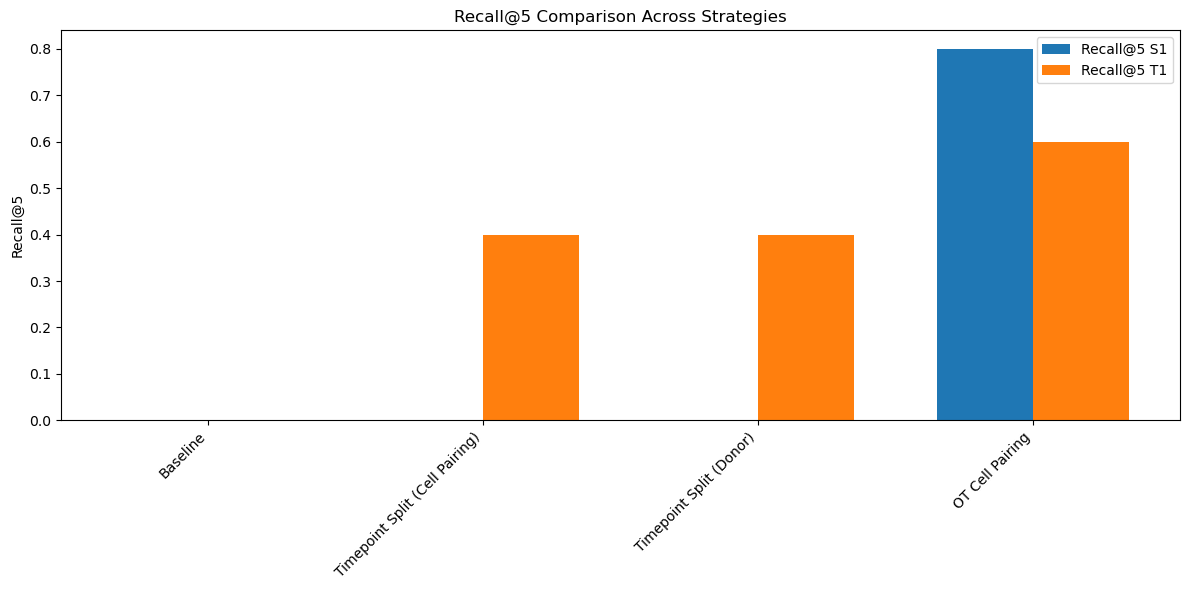

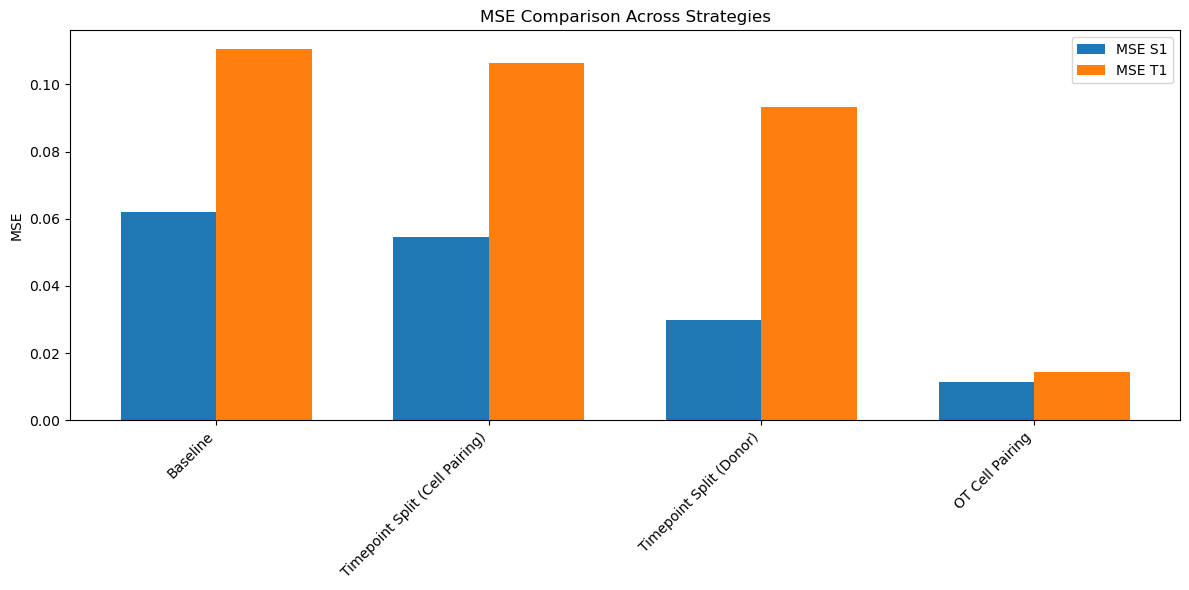

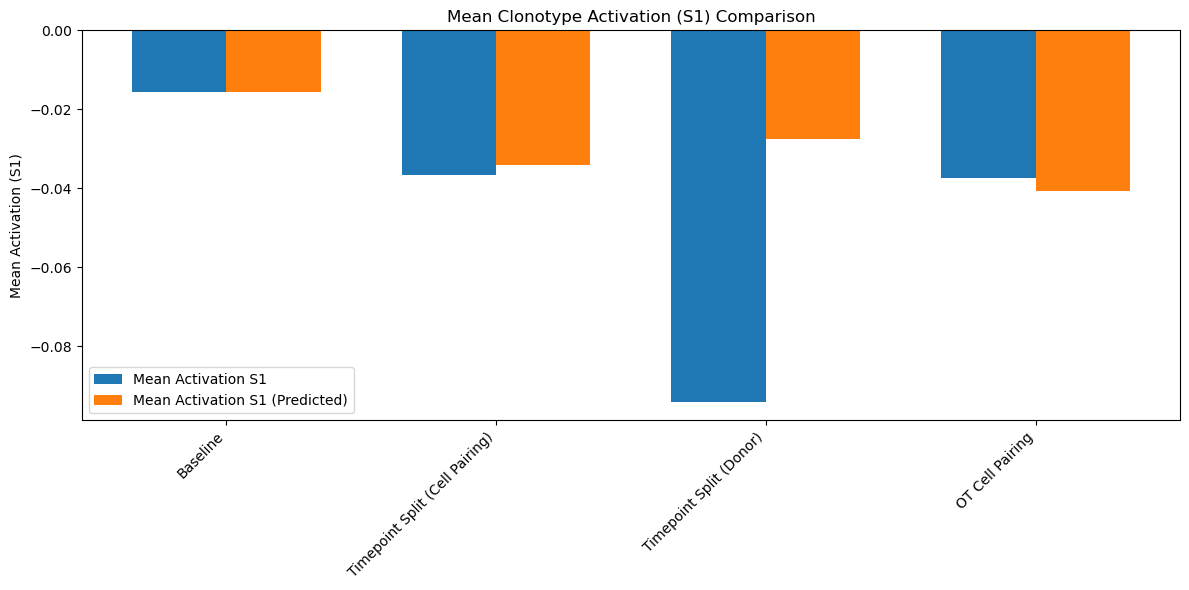

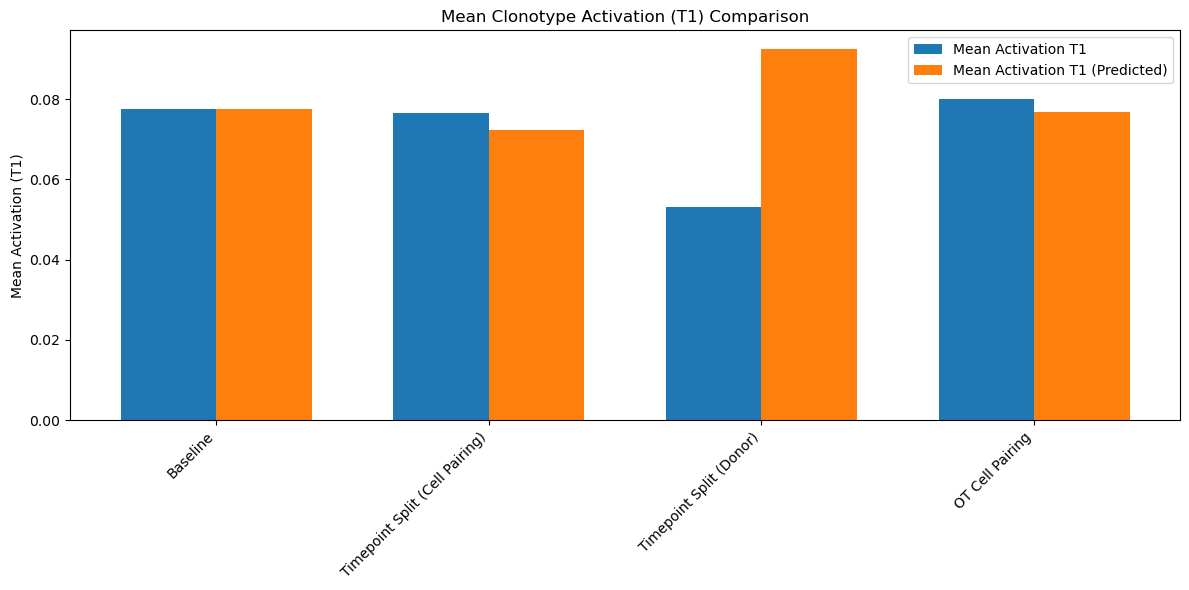

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
strategies = [
    "Baseline", 
    "Timepoint Split (Cell Pairing)", 
    "Timepoint Split (Donor)", 
    "OT Cell Pairing"
]
models = ["LinReg", "Grad Boosting", "NN"]

# Metrics for S1 and T1
recall_s1 = [0.00, 0.00, 0.00, 0.80]
recall_t1 = [0.00, 0.40, 0.40, 0.60]

mse_s1 = [0.0621, 0.0547, 0.0299, 0.0114]
mse_t1 = [0.1106, 0.1064, 0.0933, 0.0143]

mean_s1 = [-0.0155, -0.0367, -0.0941, -0.0373]
mean_pred_s1 = [-0.0155, -0.0342, -0.0276, -0.0408]

mean_t1 = [0.0776, 0.0765, 0.0530, 0.0799]
mean_pred_t1 = [0.0776, 0.0724, 0.0925, 0.0767]

# Create a grouped bar plot for Recall@5
x = np.arange(len(strategies))  # Position of groups

plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, recall_s1, width=bar_width, label="Recall@5 S1")
plt.bar(x + bar_width/2, recall_t1, width=bar_width, label="Recall@5 T1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Recall@5")
plt.title("Recall@5 Comparison Across Strategies")
plt.legend()
plt.tight_layout()
plt.show()

# Create a grouped bar plot for MSE
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mse_s1, width=bar_width, label="MSE S1")
plt.bar(x + bar_width/2, mse_t1, width=bar_width, label="MSE T1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("MSE")
plt.title("MSE Comparison Across Strategies")
plt.legend()
plt.tight_layout()
plt.show()

# Create a grouped bar plot for Mean Clonotype Activation
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mean_s1, width=bar_width, label="Mean Activation S1")
plt.bar(x + bar_width/2, mean_pred_s1, width=bar_width, label="Mean Activation S1 (Predicted)")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Mean Activation (S1)")
plt.title("Mean Clonotype Activation (S1) Comparison")
plt.legend()
plt.tight_layout()
plt.show()


# Create a grouped bar plot for Mean Clonotype Activation
plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, mean_t1, width=bar_width, label="Mean Activation T1")
plt.bar(x + bar_width/2, mean_pred_t1, width=bar_width, label="Mean Activation T1 (Predicted)")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Mean Activation (T1)")
plt.title("Mean Clonotype Activation (T1) Comparison")
plt.legend()
plt.tight_layout()
plt.show()


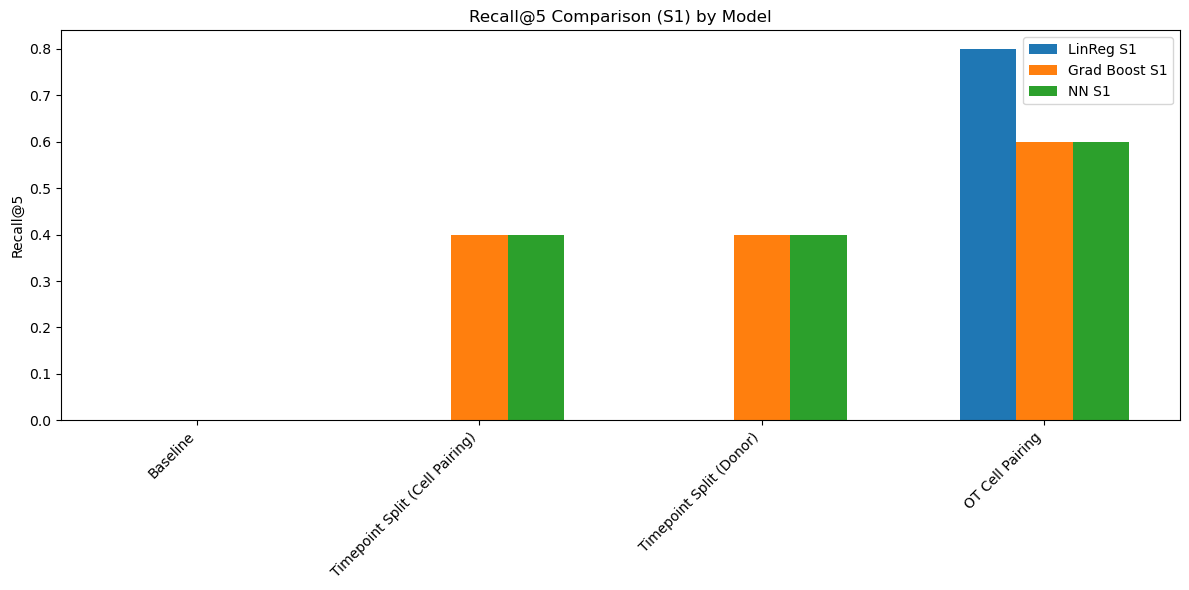

In [32]:
# TODO correct?????
# Stacked Bar Plot Example for Recall@5
plt.figure(figsize=(12, 6))
bar_width = 0.2

x = np.arange(len(strategies))

# Plot Recall for each model
plt.bar(x - bar_width, recall_s1, width=bar_width, label="LinReg S1")
plt.bar(x, recall_t1, width=bar_width, label="Grad Boost S1")
plt.bar(x + bar_width, recall_t1, width=bar_width, label="NN S1")

plt.xticks(x, strategies, rotation=45, ha="right")
plt.ylabel("Recall@5")
plt.title("Recall@5 Comparison (S1) by Model")
plt.legend()
plt.tight_layout()
plt.show()